# Existe uma linhagem celular (Vero) infectada ou não com o vírus sincicial respiratório humano (hRSV). A aquisição ocorreu a partir de padrões previamente estabelecidos, porém a sequência das imagens segue de acordo com o tempo de exposição das células ao vírus hRSV:

### Normal (controle celular) - Célula sem exposição ao vírus;
### Observação após exposição ao vírus (intervalos).

### As perguntas que podem ser realizadas nessa primeira etapa de análises são:

####- Individualmente, como a linhagem celular muda morfologicamente na presença do vírus?
####- As características morfológicas da célula ao longo das observações são diferentes?
####- Quantos núcleos são formados?
####- Quais as medidas estatísticas de cada núcleo a partir de cada observação?
####- Quais as relações existentes entre as medidas?

# Instalando as bibliotecas

In [ ]:
!pip install opencv-python
!pip install numpy
!pip install scikit-image
!pip install scipy
!pip install matplotlib
!pip install google-colab

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 9.0 MB/s eta 0:00:00


# Bibliotecas utilizadas

In [ ]:
import cv2 as cv
import numpy as np
from skimage.feature import greycomatrix, greycoprops
from scipy.stats import f_oneway
from scipy import stats
from google.colab import files
from skimage import filters
import matplotlib.pyplot as plt

# 1. Recebendo as imagens como entrada

In [ ]:
# Upload das imagens
uploaded = files.upload()
image_files = list(uploaded.keys())
images = [cv.imdecode(np.frombuffer(uploaded[file], np.uint8), cv.IMREAD_GRAYSCALE) for file in image_files]

Saving 21h.jpg to 21h.jpg
Saving 29h.jpg to 29h.jpg
Saving 44h.jpg to 44h.jpg
Saving 53h.jpg to 53h.jpg
Saving 73h.jpg to 73h.jpg
Saving 96h.jpg to 96h.jpg
Saving Normal.jpg to Normal.jpg


# 2. Aplicar Limiarização de Otsu e Watershed

In [ ]:
def aplicar_otsu(imagem):
    # Verificar se a imagem já está em escala de cinza
    if len(imagem.shape) == 2:
        imagem_gray = imagem
    else:
        # Converter para escala de cinza
        imagem_gray = cv.cvtColor(imagem, cv.COLOR_BGR2GRAY)

    # Aplicar a limiarização de Otsu
    val = filters.threshold_otsu(imagem_gray)
    segmentada = (imagem_gray > val).astype('uint8') * 255

    # Exibir imagem Otsu
    plt.imshow(segmentada, cmap='gray')
    plt.title('Segmentação Otsu')
    plt.axis('off')
    plt.show()

    return segmentada

def aplicar_watershed(imagem):
    # Verificar se a imagem está em escala de cinza
    if len(imagem.shape) == 2:
        # Converter para imagem colorida
        imagem_colorida = cv.cvtColor(imagem, cv.COLOR_GRAY2BGR)
    else:
        imagem_colorida = imagem

    # Converter para o tipo de dados esperado
    if imagem_colorida.dtype != np.uint8:
        imagem_colorida = np.uint8(imagem_colorida)

    # Converter para escala de cinza
    imagem_gray = cv.cvtColor(imagem_colorida, cv.COLOR_BGR2GRAY)

    # Aplique a limiarização de Otsu
    ret, thresh = cv.threshold(imagem_gray, 0, 255, cv.THRESH_BINARY_INV + cv.THRESH_OTSU)

    # Remover o ruído
    kernel = np.ones((3, 3), np.uint8)
    opening = cv.morphologyEx(thresh, cv.MORPH_OPEN, kernel, iterations=2)

    # Encontrar o fundo seguro
    sure_bg = cv.dilate(opening, kernel, iterations=3)

    # Encontrar o primeiro plano seguro
    dist_transform = cv.distanceTransform(opening, cv.DIST_L2, 5)
    ret, sure_fg = cv.threshold(dist_transform, 0.7 * dist_transform.max(), 255, 0)

    # Encontrar regiões desconhecidas
    sure_fg = np.uint8(sure_fg)
    unknown = cv.subtract(sure_bg, sure_fg)

    # Marcar os marcadores
    ret, markers = cv.connectedComponents(sure_fg)
    markers = markers + 1
    markers[unknown == 255] = 0

    # Aplique o algoritmo watershed
    markers = cv.watershed(imagem_colorida, markers)
    imagem_result = imagem_colorida.copy()
    imagem_result[markers == -1] = [0, 0, 255]  # Marcar bordas em vermelho

    # Exibir imagem Watershed
    plt.imshow(cv.cvtColor(imagem_result, cv.COLOR_BGR2RGB))
    plt.title('Segmentação Watershed')
    plt.axis('off')
    plt.show()

    return imagem_result

# 3. Obtendo os descritores

In [ ]:
def average_glcm(image, distances, angles):
    glcm_sum = np.zeros((256, 256, len(distances), len(angles)), dtype=np.float64)
    for i, distance in enumerate(distances):
        for j, angle in enumerate(angles):
            glcm = greycomatrix(image, [distance], [angle], 256, symmetric=True, normed=True)
            glcm_sum[:, :, i, j] += glcm[:, :, 0, 0]
    return glcm_sum

def calculate_descriptors(glcm):
    asm = greycoprops(glcm, 'ASM').mean()
    entropy = -np.sum(glcm * np.log2(glcm + (glcm == 0)))
    correlation = greycoprops(glcm, 'correlation').mean()
    contrast = greycoprops(glcm, 'contrast').mean()
    homogeneity = greycoprops(glcm, 'homogeneity').mean()
    return asm, entropy, correlation, contrast, homogeneity

# 4. Calculando a dimensão fractal

In [ ]:
def calculate_fractal_dimension(image):
    sizes = []
    counts = []

    min_dim = min(image.shape)
    sizes = [2**i for i in range(int(np.log2(min_dim)), 1, -1)]

    for size in sizes:
        count = np.sum(image[:size*(image.shape[0]//size), :size*(image.shape[1]//size)].reshape(-1, size, size).sum(axis=(1, 2)) > 0)
        counts.append(count)

    sizes_log = np.log(sizes)
    counts_log = np.log(counts)

    coef = np.polyfit(sizes_log, counts_log, 1)[0]
    return -coef

/usr/local/lib/python3.10/dist-packages/skimage/feature/__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
/usr/local/lib/python3.10/dist-packages/skimage/feature/__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
/usr/local/lib/python3.10/dist-packages/skimage/feature/__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
/usr/local/lib/python3.10/dist-packages/skimage/feature/__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
/usr/local/lib/python3.10/dist-packages/

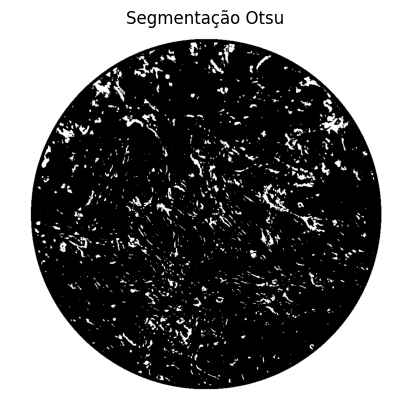

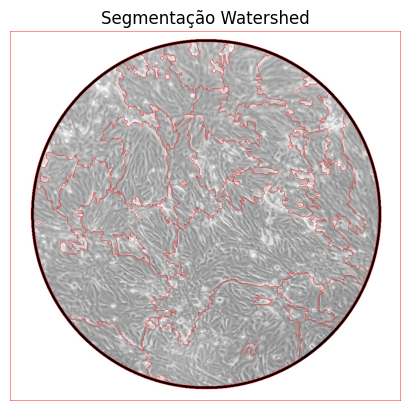

/usr/local/lib/python3.10/dist-packages/skimage/feature/__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
/usr/local/lib/python3.10/dist-packages/skimage/feature/__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
/usr/local/lib/python3.10/dist-packages/skimage/feature/__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
/usr/local/lib/python3.10/dist-packages/skimage/feature/__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
/usr/local/lib/python3.10/dist-packages/

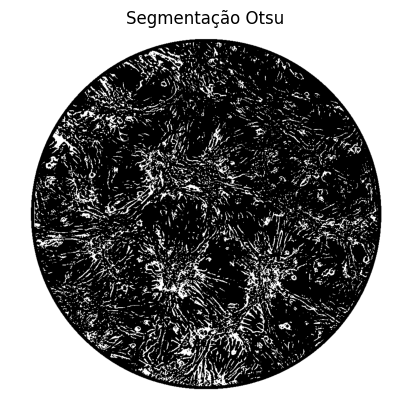

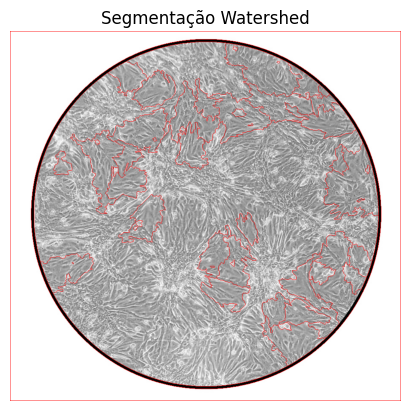

/usr/local/lib/python3.10/dist-packages/skimage/feature/__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
/usr/local/lib/python3.10/dist-packages/skimage/feature/__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
/usr/local/lib/python3.10/dist-packages/skimage/feature/__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
/usr/local/lib/python3.10/dist-packages/skimage/feature/__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
/usr/local/lib/python3.10/dist-packages/

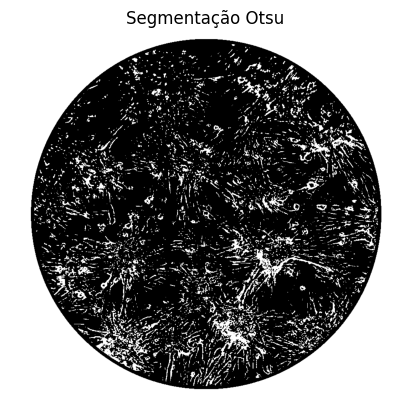

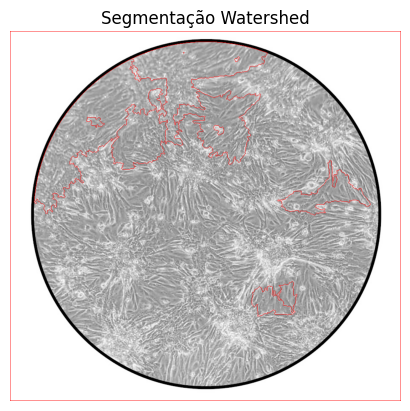

/usr/local/lib/python3.10/dist-packages/skimage/feature/__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
/usr/local/lib/python3.10/dist-packages/skimage/feature/__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
/usr/local/lib/python3.10/dist-packages/skimage/feature/__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
/usr/local/lib/python3.10/dist-packages/skimage/feature/__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
/usr/local/lib/python3.10/dist-packages/

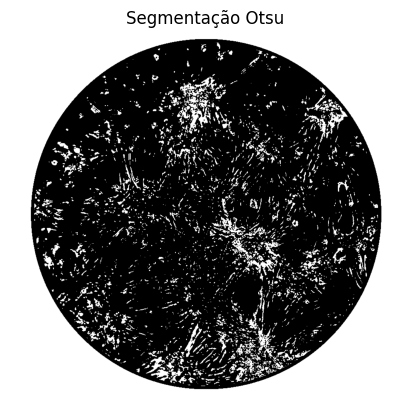

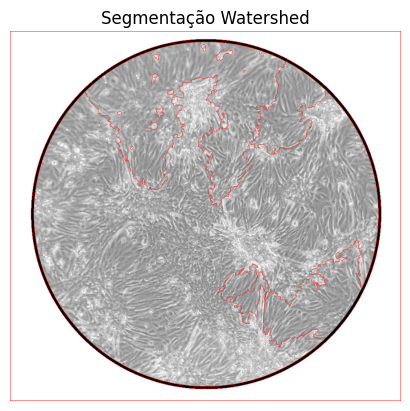

/usr/local/lib/python3.10/dist-packages/skimage/feature/__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
/usr/local/lib/python3.10/dist-packages/skimage/feature/__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
/usr/local/lib/python3.10/dist-packages/skimage/feature/__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
/usr/local/lib/python3.10/dist-packages/skimage/feature/__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
/usr/local/lib/python3.10/dist-packages/

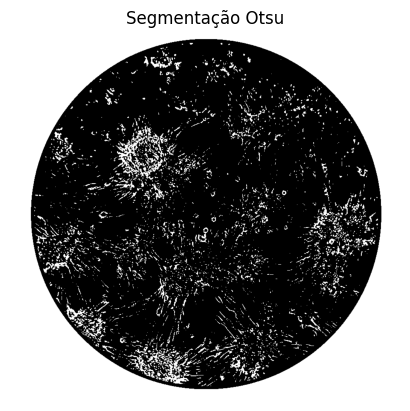

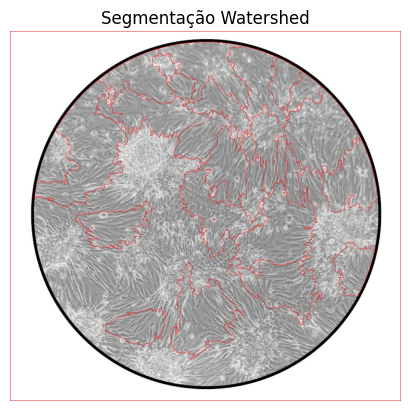

/usr/local/lib/python3.10/dist-packages/skimage/feature/__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
/usr/local/lib/python3.10/dist-packages/skimage/feature/__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
/usr/local/lib/python3.10/dist-packages/skimage/feature/__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
/usr/local/lib/python3.10/dist-packages/skimage/feature/__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
/usr/local/lib/python3.10/dist-packages/

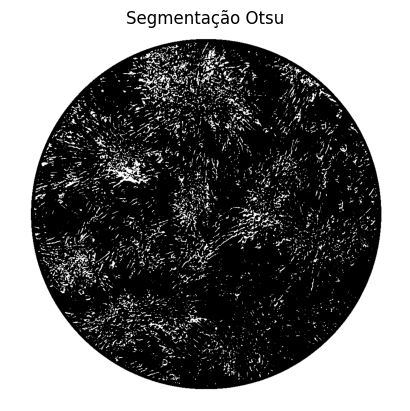

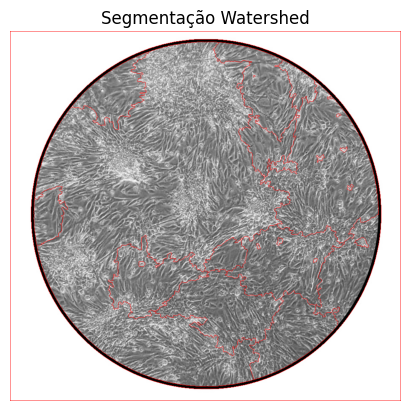

/usr/local/lib/python3.10/dist-packages/skimage/feature/__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
/usr/local/lib/python3.10/dist-packages/skimage/feature/__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
/usr/local/lib/python3.10/dist-packages/skimage/feature/__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
/usr/local/lib/python3.10/dist-packages/skimage/feature/__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
/usr/local/lib/python3.10/dist-packages/

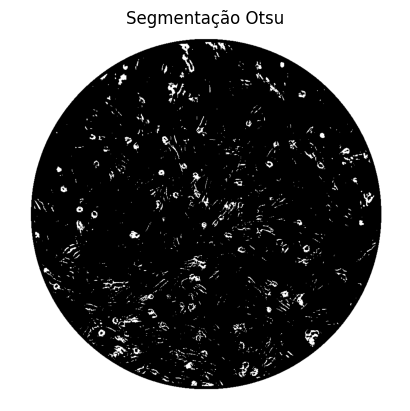

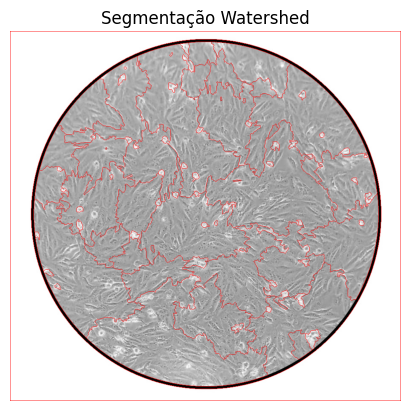

In [ ]:
distances = [1]
angles = [0, np.pi/2, np.pi, 3*np.pi/2]

feature_vectors = []
individual_descriptors = []
fractal_dimensions = []

# Processamento das imagens
for image in images:
    glcm = average_glcm(image, distances, angles)
    asm, entropy, correlation, contrast, homogeneity = calculate_descriptors(glcm)
    df = calculate_fractal_dimension(image)
    feature_vector = [asm, entropy, correlation, contrast, homogeneity, df]
    feature_vectors.append(feature_vector)
    individual_descriptors.append((asm, entropy, correlation, contrast, homogeneity))
    fractal_dimensions.append(df)

    # Aplicar segmentação Otsu
    imagem_segmentada_otsu = aplicar_otsu(image)

    # Aplicarsegmentação Watershed
    imagem_segmentada_watershed = aplicar_watershed(image)

Vetores de características para as imagens:
[[1.03071229e-01 3.43290012e+01 9.68696905e-01 1.52525495e+02
  4.51259748e-01 2.16589491e+00]
 [1.02714809e-01 3.85214559e+01 9.45923620e-01 3.06700500e+02
  3.90169366e-01 2.16589249e+00]
 [1.02703976e-01 3.72429455e+01 9.55039640e-01 2.35079403e+02
  4.04591229e-01 2.16589007e+00]
 [1.02802259e-01 3.61101977e+01 9.63571562e-01 1.90097031e+02
  4.24810751e-01 2.16589249e+00]
 [1.02693720e-01 3.66040469e+01 9.62841371e-01 2.08827283e+02
  4.16686489e-01 2.16589491e+00]
 [1.02646051e-01 3.93950304e+01 9.60233222e-01 3.35995097e+02
  3.85359170e-01 2.16589249e+00]
 [1.02924081e-01 3.46975174e+01 9.64347827e-01 1.83919223e+02
  4.45753621e-01 2.16589249e+00]]

Descritores individuais para cada imagem:
Imagem 1: ASM=0.10307122901562983, Entropy=34.32900124228463, Correlation=0.9686969052872503, Contrast=152.52549466949785, Homogeneity=0.4512597483296896
Imagem 2: ASM=0.10271480852140621, Entropy=38.52145592006479, Correlation=0.9459236195740252,

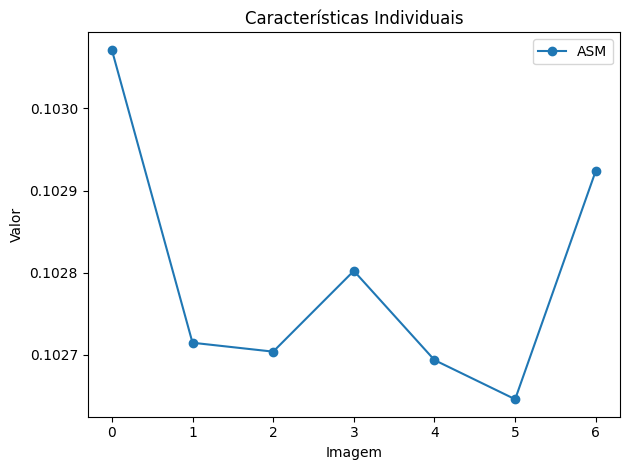

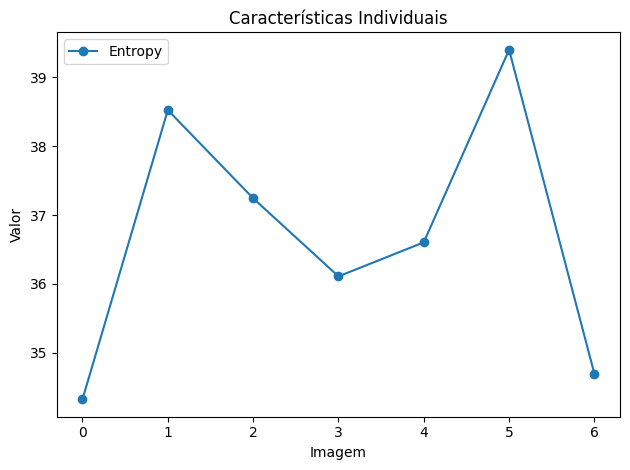

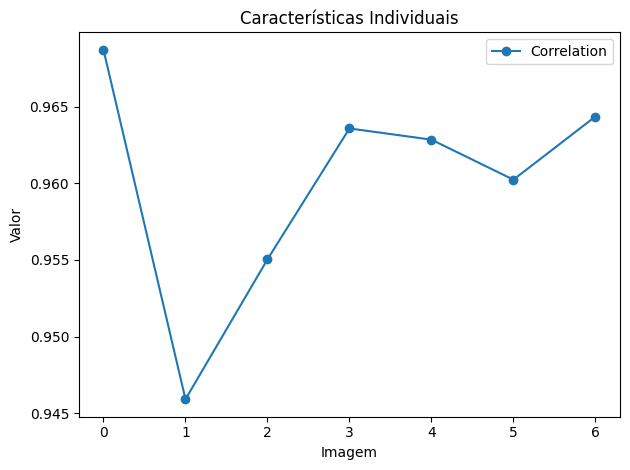

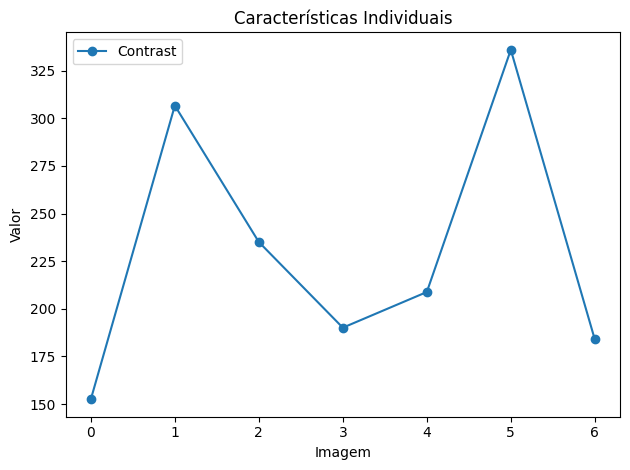

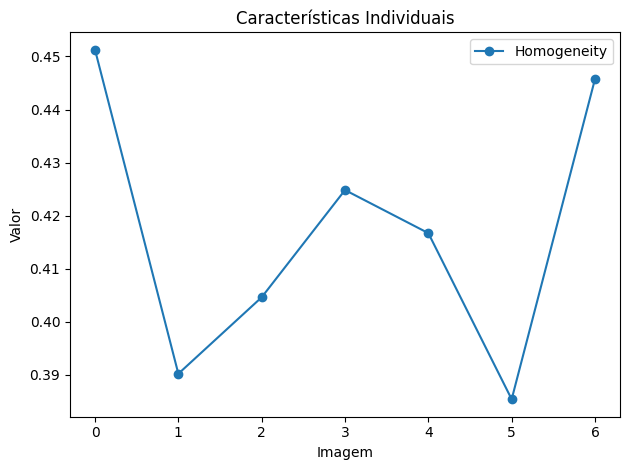

In [ ]:
#Organizando vetores de características
feature_vectors = np.array(feature_vectors)

print("Vetores de características para as imagens:")
print(feature_vectors)

print("\nDescritores individuais para cada imagem:")
for i, desc in enumerate(individual_descriptors):
  print(f"Imagem {i+1}: ASM={desc[0]}, Entropy={desc[1]}, Correlation={desc[2]}, Contrast={desc[3]}, Homogeneity={desc[4]}")

print("\nDimensão Fractal para cada imagem:")
for i, df in enumerate(fractal_dimensions):
  print(f"Imagem {i+1}: Dimensão Fractal={df}")

#Gráfico das características individuais
plt.subplot()
feature_vectors_T = feature_vectors.T # Transpor para plotagem
labels = ['ASM', 'Entropy', 'Correlation', 'Contrast', 'Homogeneity']
for i, label in enumerate(labels):
  plt.plot(feature_vectors_T[i], marker='o', label=label)
  plt.title('Características Individuais')
  plt.xlabel('Imagem')
  plt.ylabel('Valor')
  plt.legend()

  plt.tight_layout()
  plt.show()


# 6. Visualização do Espaço de Características

In [1]:
import matplotlib.pyplot as plt

# Nomes dos descritores para usar nos rótulos dos eixos
nomes_descritores = [
    "Segundo Momento Angular",
    "Entropia",
    "Correlação",
    "Contraste",
    "Homogeneidade",
    "Dimensão Fractal"
]

# Definindo os pares de características para visualizar
pares_caracteristicas = [
    (0, 1),  # Segundo Momento Angular vs. Entropia
    (0, 5),  # Segundo Momento Angular vs. Dimensão Fractal
    (1, 5),  # Entropia vs. Dimensão Fractal
    (3, 4)   # Contraste vs. Homogeneidade
]

# Criando os gráficos de dispersão
for i, (carac_x, carac_y) in enumerate(pares_caracteristicas):
    plt.figure(figsize=(8, 6))
    plt.scatter(feature_vectors[:1, carac_x], feature_vectors[:1, carac_y],
                color='blue', label='Controle', marker='o', s=100)
    plt.scatter(feature_vectors[1:, carac_x], feature_vectors[1:, carac_y],
                color='red', label='Tratamento', marker='x', s=100)

    plt.xlabel(nomes_descritores[carac_x])
    plt.ylabel(nomes_descritores[carac_y])
    plt.title(f"Espaço de Características - {nomes_descritores[carac_x]} vs. {nomes_descritores[carac_y]}")
    plt.legend(loc='best')  # Posição da legenda otimizada
    plt.grid(True)          # Adicionando grid para melhor visualização
    plt.show()

NameError: name 'feature_vectors' is not defined

<Figure size 800x600 with 0 Axes>

# 7. Teste T de Student


In [ ]:
# --- Divisão em Grupos ---
grupo_controle = feature_vectors[0]  # Imagem normal (índice 0)
grupo_tratamento = feature_vectors[1:]  # Imagens com vírus (índices 1 em diante)

# --- Teste t de Student para cada descritor ---
for i, descritor in enumerate(['Segundo Momento Angular', 'Entropia', 'Correlação', 'Contraste', 'Homogeneidade', 'DF']):
    # Realizando o Teste t
    resultado_ttest = stats.ttest_ind(grupo_controle[i], grupo_tratamento[:, i])

    print(f"Resultado do Teste t para {descritor}:")
    print(f"  Estatística t: {resultado_ttest.statistic:.2f}")
    print(f"  Valor-p: {resultado_ttest.pvalue:.3f}")

    # Interpretação do resultado
    alpha = 0.2
    if resultado_ttest.pvalue < alpha:
        print(f"  Conclusão: Existe diferença significativa entre as médias do descritor '{descritor}' (p < {alpha}).\n")
    else:
        print(f"  Conclusão: Não há evidência de diferença significativa entre as médias do descritor '{descritor}' (p >= {alpha}).\n")

Resultado do Teste t para Segundo Momento Angular:
  Estatística t: 2.99
  Valor-p: 0.031
  Conclusão: Existe diferença significativa entre as médias do descritor 'Segundo Momento Angular' (p < 0.2).

Resultado do Teste t para Entropia:
  Estatística t: -1.51
  Valor-p: 0.190
  Conclusão: Existe diferença significativa entre as médias do descritor 'Entropia' (p < 0.2).

Resultado do Teste t para Correlação:
  Estatística t: 1.31
  Valor-p: 0.247
  Conclusão: Não há evidência de diferença significativa entre as médias do descritor 'Correlação' (p >= 0.2).

Resultado do Teste t para Contraste:
  Estatística t: -1.32
  Valor-p: 0.243
  Conclusão: Não há evidência de diferença significativa entre as médias do descritor 'Contraste' (p >= 0.2).

Resultado do Teste t para Homogeneidade:
  Estatística t: 1.64
  Valor-p: 0.163
  Conclusão: Existe diferença significativa entre as médias do descritor 'Homogeneidade' (p < 0.2).

Resultado do Teste t para DF:
  Estatística t: 1.46
  Valor-p: 0.203


# Cálculo de Estatísticas Descritivas

In [ ]:
# --- Cálculo de Estatísticas Descritivas ---

for i, descritor in enumerate(['Segundo Momento Angular', 'Entropia', 'Correlação', 'Contraste', 'Homogeneidade', 'DF']):
    # Extraindo os valores do descritor para cada imagem
    valores_descritor = feature_vectors[:, i]

    # Calculando estatísticas descritivas
    media = np.mean(valores_descritor)
    desvio_padrao = np.std(valores_descritor)
    valor_minimo = np.min(valores_descritor)
    valor_maximo = np.max(valores_descritor)

    print(f"Estatísticas Descritivas para {descritor}:")
    print(f"  Média: {media:.2f}")
    print(f"  Desvio Padrão: {desvio_padrao:.2f}")
    print(f"  Valor Mínimo: {valor_minimo:.2f}")
    print(f"  Valor Máximo: {valor_maximo:.2f}\n")

Estatísticas Descritivas para Segundo Momento Angular:
  Média: 0.10
  Desvio Padrão: 0.00
  Valor Mínimo: 0.10
  Valor Máximo: 0.10

Estatísticas Descritivas para Entropia:
  Média: 36.70
  Desvio Padrão: 1.73
  Valor Mínimo: 34.33
  Valor Máximo: 39.40

Estatísticas Descritivas para Correlação:
  Média: 0.96
  Desvio Padrão: 0.01
  Valor Mínimo: 0.95
  Valor Máximo: 0.97

Estatísticas Descritivas para Contraste:
  Média: 230.45
  Desvio Padrão: 62.46
  Valor Mínimo: 152.53
  Valor Máximo: 336.00

Estatísticas Descritivas para Homogeneidade:
  Média: 0.42
  Desvio Padrão: 0.02
  Valor Mínimo: 0.39
  Valor Máximo: 0.45

Estatísticas Descritivas para DF:
  Média: 2.17
  Desvio Padrão: 0.00
  Valor Mínimo: 2.17
  Valor Máximo: 2.17

